In [1]:
import pandas as pd
from toolbox import DatabaseInterface
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns


databaseInterface = DatabaseInterface()
def load_data(query):
    return(databaseInterface.select(query))

connected to azure database main


In [2]:
query_city = """
    SELECT article_date, content_cities.city, latitude, longitude
    FROM articles
    JOIN contents ON articles.id = contents.article_id
    JOIN content_cities ON contents.id = content_cities.content_id
    JOIN geocity ON content_cities.city = geocity.city
    ORDER BY article_date
    ;
    """
df_city = load_data(query_city)

In [3]:
df_city["city"] = df_city["city"].str.capitalize()

In [4]:
def countplot(df: pd.DataFrame, feature: str):
    chart = sns.countplot(df, x=feature, order=df[feature].value_counts().index)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right')
    sns.set(rc={'figure.figsize':(10,5)});

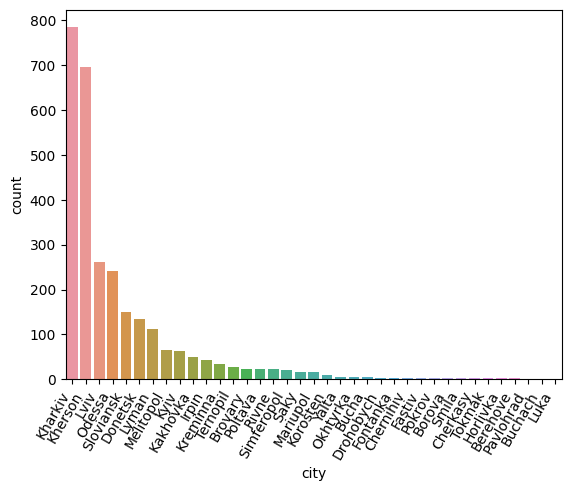

In [5]:
countplot(df_city, "city")

In [6]:
df_city

,article_date,city,latitude,longitude
0,2000-06-15 00:00:00,Odessa,46.484303,30.732288
1,2004-11-20 12:31:00,Lviv,49.841953,24.031591
2,2004-12-03 13:24:00,Kherson,46.542170,33.407932
3,2006-11-24 14:15:00,Kharkiv,49.992317,36.231014
4,2012-06-08 10:17:00,Lviv,49.841953,24.031591
...,...,...,...,...
2836,2023-03-06 06:51:00,Kherson,46.542170,33.407932
2837,2023-03-06 06:51:00,Lyman,43.917637,-99.858160
2838,2023-03-06 07:20:00,Lviv,49.841953,24.031591
2839,2023-03-08 05:00:00,Lyman,43.917637,-99.858160


In [7]:
df_mapcity = df_city.groupby(["city", "latitude", "longitude"]).count().sort_values("article_date", ascending=False).reset_index()
df_mapcity = df_mapcity.rename(columns={"article_date": "count"})

In [8]:
df_mapcity = df_mapcity.dropna()

In [9]:
df_mapcity

,city,latitude,longitude,count
0,Kharkiv,49.992317,36.231014,784
1,Kherson,46.542170,33.407932,695
2,Lviv,49.841953,24.031591,262
3,Odessa,46.484303,30.732288,241
4,Sloviansk,48.852270,37.605824,151
5,Donetsk,48.015877,37.801342,134
6,Lyman,43.917637,-99.858160,112
7,Melitopol,46.846725,35.382730,65
8,Kyiv,50.450035,30.524136,64
9,Kakhovka,46.805460,33.481780,50


In [22]:
import plotly.express as px

# Data with latitude/longitude and values
fig = px.scatter_mapbox(
    df_mapcity,
    lat="latitude",
    lon="longitude",
    size="count",
    color="count",
    color_continuous_scale=px.colors.cyclical.IceFire,
    hover_name="city",
    zoom=3,
    mapbox_style="open-street-map",
    height=700,
    size_max=40
)

fig.show()

In [36]:
import qwikidata
import qwikidata.sparql

def get_city_wikidata(city, country):
    query = """
    SELECT ?city ?cityLabel ?country ?countryLabel ?population
    WHERE
    {
      ?city rdfs:label '%s'@en.
      ?city wdt:P1082 ?population.
      ?city wdt:P17 ?country.
      ?city rdfs:label ?cityLabel.
      ?country rdfs:label ?countryLabel.
      FILTER(LANG(?cityLabel) = "en").
      FILTER(LANG(?countryLabel) = "en").
      FILTER(CONTAINS(?countryLabel, "%s")).
    }
    """ % (city, country)

    res = qwikidata.sparql.return_sparql_query_results(query)
    out = res['results']['bindings'][0]
    return out

get_city_wikidata('Berlin', 'Germany')

{'city': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q64'},
 'population': {'datatype': 'http://www.w3.org/2001/XMLSchema#decimal',
  'type': 'literal',
  'value': '3677472'},
 'country': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q183'},
 'cityLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Berlin'},
 'countryLabel': {'xml:lang': 'en', 'type': 'literal', 'value': 'Germany'}}